# ch04.04 Style Transfer

* 날짜: 2022.08.17
* 이름: 윤태우

## 학습내용
    - Style transfer에 대해 이해하고 코드로 구현한다.
    - Stlye transfer를 사용하여 이미지의 스타일을 바꾼다.

* [논문: Image Style Transfer Using Convolutional Neural Networks](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf)
* [Keras 실습 참고 코드](https://keras.io/examples/generative/neural_style_transfer/)

<p align='center'>
<img  src ='https://www.popit.kr/wp-content/uploads/2018/04/gatys_style_transfer.jpg' width=700>
</p>

## 이미지 전처리
---

In [ ]:
import tensorflow as tf
from tensorflow.keras import preprocessing, utils, applications, models
import numpy as np
import matplotlib.pyplot as plt

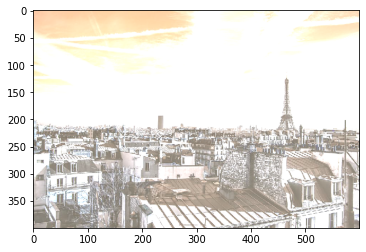

In [ ]:
class ImgPreprocess() :

  def __init__(self, combi_shape, base_model=applications.vgg19) :
    self.combi_shape = combi_shape
    self.base_model = base_model

  # 이미지 경로 -> (전처리 된) 텐서 변환
  def path2tensor(self, img_path) :
    img = preprocessing.image.load_img(img_path, target_size = self.combi_shape[:2])
    img = preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    # img = self.base_model.preprocess_input(img)
    img = tf.convert_to_tensor(img)
    return img
    
  # (전처리 된) 텐서 -> (전처리 전) 텐서 이미지
  def tensor2img(self, tensor) :
    x = tensor.numpy()
    x = x.reshape(self.combi_shape)

    # vgg 전처리 되돌리기
    x[:,:,0] += 103.939
    x[:,:,1] += 116.779
    x[:,:,2] += 123.68
    x = x[:,:,::-1]
    x = np.clip(x,0,255).astype('uint8')
    return x

  def display_imgs(target_img, ref_img, combi_img=None):
    plt.figure(figsize=(20,5))
    plt.subplot(131);plt.axis('off')
    plt.imshow(target_img);plt.title('Target img (for content')
    plt.subplot(132);plt.axis('off')
    plt.imshow(ref_img);plt.title('Reference img (for style)')
    if combi_img is not None: 
      plt.subplot(133);plt.axis('off')
      plt.imshow(comni_img);plt.title('Combination img')
    plt.show()
  

combi_shape = (400,600,3)
base_model = 'vgg'
p = ImgPreprocess(combi_shape,base_model)
t = p.path2tensor('origin01.jpg')
img = p.tensor2img(t)
plt.imshow(img)

![](https://s3.amazonaws.com/book.keras.io/img/ch8/style_transfer.png)

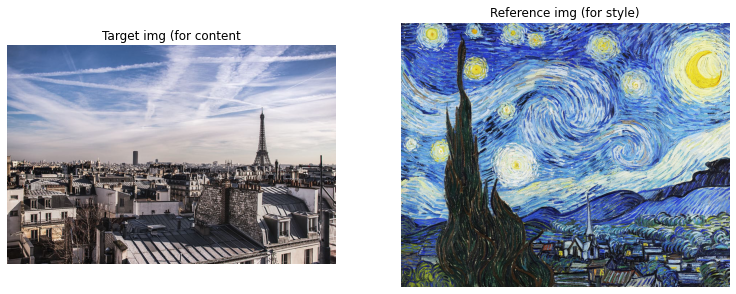

In [ ]:
def display_imgs(target_img, ref_img, combi_img=None):
  plt.figure(figsize=(20,5))
  plt.subplot(131);plt.axis('off')
  plt.imshow(target_img);plt.title('Target img (for content')
  plt.subplot(132);plt.axis('off')
  plt.imshow(ref_img);plt.title('Reference img (for style)')
  if combi_img is not None: 
    plt.subplot(133);plt.axis('off')
    plt.imshow(combi_img);plt.title('Combination img')
  plt.show()
target_img = plt.imread('origin01.jpg')
ref_img = plt.imread('style01.jpg')
display_imgs(target_img, ref_img)

## 모델 준비
---

<p align='center'>
<img  src ='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FzzZ6d%2FbtqtZOLsxg8%2Fdykdt2eKeWaxRFx8iyzEE0%2Fimg.png
' width=500>
</p>


In [ ]:
COMBI_SHAPE = (400,600,3)
BASE_MODEL = applications.vgg19

#### **특성 추출기**

In [ ]:
model = BASE_MODEL.VGG19(include_top = False, weights = 'imagenet', input_shape = COMBI_SHAPE)
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 400, 600, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 400, 600, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 400, 600, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 200, 300, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 200, 300, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 200, 300, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 100, 150, 128)     0     

In [ ]:
layers = model.layers
outputs_dic = dict([(layer.name, layer.output) for layer in layers])
extractor = models.Model(inputs = model.inputs, outputs = outputs_dic)

#### **이미지 텐서 준비**

In [ ]:
p = ImgPreprocess(COMBI_SHAPE, BASE_MODEL)
# target(content)
target_tensor = p.path2tensor('origin01.jpg')
# reference(stype)
refer_tensor = p.path2tensor('style01.jpg')
# combination
combi_tensor = tf.Variable(p.path2tensor('origin01.jpg')) # Variable : 학습 도중 값이 알아서 다양하게 변함
print(target_tensor.shape, refer_tensor.shape, combi_tensor.shape)

(1, 400, 600, 3) (1, 400, 600, 3) (1, 400, 600, 3)


#### **특성 추출**

In [ ]:
inputs = tf.concat([target_tensor, refer_tensor, combi_tensor], axis = 0)
print('인풋 : ', inputs.shape)

outputs = extractor(inputs)
print('아웃풋(레이어마다) : ', len(outputs))

인풋 :  (3, 400, 600, 3)
아웃풋(레이어마다) :  22


## 손실 정의
---

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FboAUdP%2Fbtqt7RHqZqN%2Fx6SxUNLAdhpBw7J5JcK08k%2Fimg.png)

### **| 컨텐츠 손실**

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FclyRn2%2Fbtqt4yhBuoM%2FA6LcrtitH46HHzqYu40vo1%2Fimg.png)

#### **컨텐츠 손실 정의**

In [ ]:
for i in extractor.layers:
    print(i.name, "\t\t\t",i.output.shape)

input_3 			 (None, 400, 600, 3)
block1_conv1 			 (None, 400, 600, 64)
block1_conv2 			 (None, 400, 600, 64)
block1_pool 			 (None, 200, 300, 64)
block2_conv1 			 (None, 200, 300, 128)
block2_conv2 			 (None, 200, 300, 128)
block2_pool 			 (None, 100, 150, 128)
block3_conv1 			 (None, 100, 150, 256)
block3_conv2 			 (None, 100, 150, 256)
block3_conv3 			 (None, 100, 150, 256)
block3_conv4 			 (None, 100, 150, 256)
block3_pool 			 (None, 50, 75, 256)
block4_conv1 			 (None, 50, 75, 512)
block4_conv2 			 (None, 50, 75, 512)
block4_conv3 			 (None, 50, 75, 512)
block4_conv4 			 (None, 50, 75, 512)
block4_pool 			 (None, 25, 37, 512)
block5_conv1 			 (None, 25, 37, 512)
block5_conv2 			 (None, 25, 37, 512)
block5_conv3 			 (None, 25, 37, 512)
block5_conv4 			 (None, 25, 37, 512)
block5_pool 			 (None, 12, 18, 512)


In [ ]:
content_layer = 'block5_conv2'
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

In [ ]:
# 3개의 이미지에 대한 3개의 컨텐츠가 존재
# 이중에서 우리가 참고할 컨텐츠는 'target' 이미지의 컨텐츠
# target 과 combi 의 컨텐츠 차이가 적도록

def get_content_loss(target_content, combi_content) :
  return 0.5 * tf.reduce_sum( tf.square( target_content - combi_content ) )

#### **컨텐츠 손실 계산**

In [ ]:
# 컨텐츠는 특정 레이어의 아웃풋을 일컫는다.
contents = outputs[content_layer]
print(contents.shape)

target_content = contents[0]
combi_content = contents[2]

# 컨텐츠 손실 계싼
content_loss = get_content_loss(target_content, combi_content)
print(f'{content_loss.numpy() :.6f}' )

(3, 25, 37, 512)
0.000000


### **| 스타일 손실**

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FE2teK%2FbtqubfnwDl2%2F9WdiAMbhEKKL9SNNfQqdlk%2Fimg.png)


#### **그램(gram) 매트릭스**

In [ ]:
def gram(x) : # x = (h, w, c)
  x = tf.transpose(x, (2,0,1)) # x : (ch, h, w)
  x = tf.reshape(x, (tf.shape(x)[0], -1)) # x : (ch, h*w)
  return tf.matmul(x, tf.transpose(x))

contents[1].shape, gram(contents[1]).shape

(TensorShape([25, 37, 512]), TensorShape([512, 512]))

#### **스타일 손실 정의**

In [ ]:
# N: 피쳐맵(style)의 채널 수
# M: 피쳐맵(style)의 resolution(h*w)
# G: 피쳐맵(reference style)을 그램 매트릭스로 변환한것
# A: 피쳐맵(combination style)을 그램 매트릭스로 변환한것
def get_style_loss(refer_style, combi_style):
  N = refer_style.shape[2]
  M = refer_style.shape[0]*refer_style[1]
  G = gram(refer_style)
  A = gram(combi_style)
  return tf.reduce_sum( tf.square( G - A )  )  / (4 * (N**2) * (M**2) )

#### **스타일 손실 계산**

In [ ]:

# 스타일은 특정 레이어들의 아웃풋들을 일컫는다.
for style_layer in style_layers:
  styles = outputs[style_layer]

  # 스타일 손실에 필요한 건 reference - combi
  refer_style = styles[1]
  combi_style = styles[2]

  # 스타일 손실을 계산 합니다.
  style_loss = get_style_loss(refer_style, combi_style)
  print(style_layer, refer_style.shape, combi_style.shape, f'loss: {style_loss.shape}')

block1_conv1 (400, 600, 64) (400, 600, 64) loss: (600, 64)
block2_conv1 (200, 300, 128) (200, 300, 128) loss: (300, 128)
block3_conv1 (100, 150, 256) (100, 150, 256) loss: (150, 256)
block4_conv1 (50, 75, 512) (50, 75, 512) loss: (75, 512)
block5_conv1 (25, 37, 512) (25, 37, 512) loss: (37, 512)


#### **| 총 변위 손실**

* 생성된 이미지가 공간적인 연속성을 가지도록 도와준다.
* 픽셀의 격자무늬가 과도하게 나타나는 것을 막아 준다.
* 일종의 규제 항으로 해석할 수 있다.

## 학습
---

### **| 학습을 위한 손실 함수 정리**

In [ ]:

# loss

def get_content_loss(target_content, combi_content):
  return 0.5*tf.reduce_sum(  tf.square( target_content - combi_content) )

def get_style_loss(refer_style, combi_style):
  N = refer_style.shape[2]
  M = refer_style.shape[0]*refer_style.shape[1]
  G = gram(refer_style)
  A = gram(combi_style)
  return tf.reduce_sum( tf.square( G - A )  )  / (4 * (N**2) * (M**2) ) 

def gram(x): # x: (h, w, ch)
  x = tf.transpose(x, (2, 0, 1)) # x : (ch, h, w )
  x = tf.reshape(x, (tf.shape(x)[0], -1 ) ) # x: (ch, h*w )
  return tf.matmul(x, tf.transpose(x) )


def comput_loss(target_tensor, 
                refer_tensor, 
                combi_tensor,
                alpha=0.01,
                beta= 0.00001
                ):
  # 특성 추출
  inputs = tf.concat([target_tensor, refer_tensor, combi_tensor], axis=0)
  outputs = extractor(inputs)

  # 컨텐츠 손실
  contents = outputs[content_layer]
  target_content = contents[0, :, :, :]  
  combi_content = contents[2, :, :, :]
  content_loss = get_content_loss(target_content, combi_content)

  # 스타일 손실
  style_loss = tf.zeros(shape=())
  for style_layer in style_layers:
    styles = outputs[style_layer]
    refer_style = styles[1,:,:,:]
    combi_style = styles[2,:,:,:]
    style_loss += get_style_loss(refer_style, combi_style)
  style_loss = style_loss / len(style_layers)

  # 최종 손실 (= alpha * 컨텐츠 손실 + beta * 스타일 손실)
  loss = (alpha * content_loss) + (beta * style_loss)

  return loss

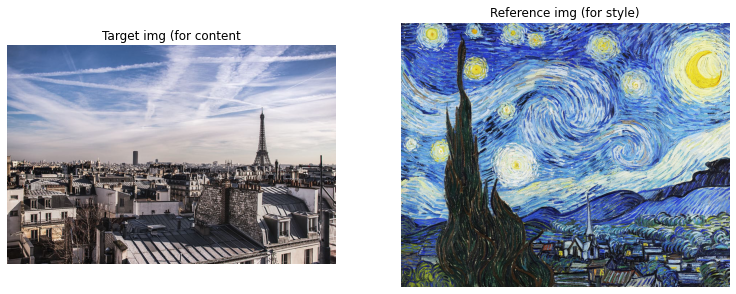

In [ ]:
TARGET_SAHPE = (400, 600, 3)
p = ImgPreprocess(TARGET_SAHPE)
# 이미지를 준비한다.
target_path = 'origin01.jpg'
refer_path = 'style01.jpg'
target_img = plt.imread(target_path)
refer_img = plt.imread(refer_path)
display_imgs(target_img, refer_img)
# 전처리 (tensor)
target_tensor= p.path2tensor(target_path)
refer_tensor= p.path2tensor(refer_path)
#combi_tensor= tf.Variable(p.path2tensor(target_path))

In [ ]:

from tensorflow.keras import optimizers
# 훈련을 한다. -> 각종 손실함수를 정의해야 한다.
# loss를 줄이자! loss에 영향을 미치는건 combi_tensor
@tf.function
def compute_loss_grads(target_tensor, refer_tensor, combi_tensor,
                      alpha, beta):
  with tf.GradientTape() as tape:
    loss = comput_loss(target_tensor, refer_tensor, combi_tensor,
                      alpha, beta)
  grads = tape.gradient(loss, combi_tensor)
  return loss, grads

opt = optimizers.SGD(optimizers.schedules.ExponentialDecay(initial_learning_rate=100.0,
                                                          decay_steps=100, 
                                                           decay_rate=0.96) )

In [ ]:
iters = 1000
for i in range(iters):
  loss, grads = compute_loss_grads(target_tensor, 
                                  refer_tensor,
                                  combi_tensor,
                                  alpha = 1e-10, 
                                  beta = 4e-6)
  opt.apply_gradients([(grads, combi_tensor)])
  if i%100 == 0:
    print(f'> iter {i}/{iters} : {loss.numpy():.4f}')

> iter 0/1000 : 106458.3984
> iter 100/1000 : 881.3022
> iter 200/1000 : 527.0242
> iter 300/1000 : 395.1380
> iter 400/1000 : 324.8878
> iter 500/1000 : 281.2129
> iter 600/1000 : 251.1450
> iter 700/1000 : 229.0893
> iter 800/1000 : 212.1915
> iter 900/1000 : 198.7271


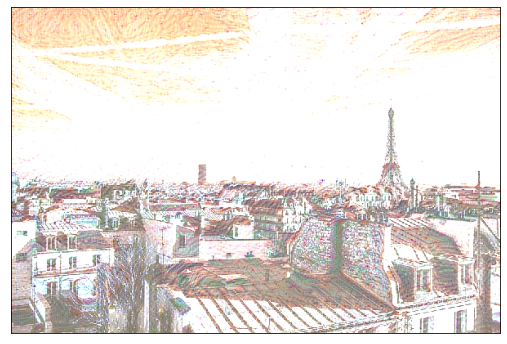

In [ ]:
result = p.tensor2img(combi_tensor)
# display_imgs(target_img, refer_img, result)
plt.figure(figsize = (10,6));plt.xticks([]);plt.yticks([])
plt.imshow(result)
plt.savefig('result02.png')